### Data source: https://www.bracs.icar.cnr.it/

### Import packages

In [1]:
import numpy as np
#from geojson import GeoJSON
import json
import os
import glob
import shapely
from rtree import index
from shapely.ops import cascaded_union, unary_union
from collections import Counter
import matplotlib.pyplot as plt

### Locate annotations

In [2]:
annotation_folder = '/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/BRACS_EXPORT_GEOJSON/'

In [3]:
annotation_list = np.array( sorted( [ i for i in os.listdir(annotation_folder) if 'geo' in i ] ) )
annotation_list.shape
# only on 387 slides are annotations

(385,)

### Test process

In [4]:
json_fname = annotation_folder + annotation_list[360]

with open(json_fname) as f:
    data = json.load(f)

data.keys()

dict_keys(['type', 'features'])

In [5]:
json_fname

'/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/BRACS_EXPORT_GEOJSON/BRACS_3320.geojson'

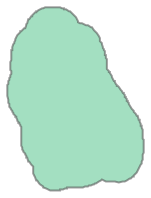

In [6]:
shapely.Polygon(np.array(data['features'][0]['geometry']['coordinates'][0])//16)

In [7]:
data['features'][4]['properties']['classification']['name']

'MALIGNANT'

In [8]:
data_coords_all = []
data_type_all = []
data_label_all = []
for feature in data['features']:
    data_type = feature['geometry']['type']
    data_type_all.append(data_type)
    data_coords = feature['geometry']['coordinates'][0]
    data_coords_all.append(data_coords)
    data_label = feature['properties']['classification']['name']
    data_label_all.append(data_label)

### Automate

In [9]:
annot_bracs_old = np.array(['ADH', 'ADH-sure', 'BENIGN', 'Benign sure', 'Benign-sure', 'DCIS',
       'DCIS-sure', 'FEA', 'FEA-sure', 'MALIGNANT', 'Malignant',
       'Malignant-sure', 'Pathologica benign', 'Pathological-benign',
       'Pathological-benign (Benign-sure)', 'UDH', 'UDH-sure'])


annot_bracs_new = np.array(['ADH', 'ADH', 'NORMAL', 'NORMAL', 'NORMAL', 'DCIS',
       'DCIS', 'FEA', 'FEA', 'INVASIVE-CARCINOMA', 'INVASIVE-CARCINOMA',
       'INVASIVE-CARCINOMA', 'PATHOLOGICAL-BENIGN', 'PATHOLOGICAL-BENIGN',
       'PATHOLOGICAL-BENIGN', 'UDH', 'UDH'])

annot_map = dict(zip(annot_bracs_old, annot_bracs_new))

In [10]:
def extract_json( abspath ):
    
    with open(abspath) as f:
        data = json.load(f)

    data_polygon_all = []
    data_label_all = []
    for feature in data['features']:
        

        try:
            
            data_polygon = shapely.Polygon(np.array(feature['geometry']['coordinates'][0])//16)
            data_polygon_all.append(data_polygon)
        
        except:
            print(feature)
            
        
        
        data_label = feature['properties']['classification']['name']
        data_label = annot_map[data_label] # map annots
        data_label_all.append(data_label)
    
    # then create polygons and return that at the end instead of the coords
    
    return data_polygon_all, data_label_all

In [11]:
polygons_all = []
labels_all = []

for i in range( len(annotation_list) ): 
    polygons, labels =  extract_json(annotation_folder+annotation_list[i])

    assert len(polygons) == len(labels)
    
    labels_all.append(labels)
    polygons_all.append(polygons)
    
#labels_all = np.concatenate(labels_all)
#polygons_all = np.concatenate(polygons_all)
len(labels_all), len(polygons_all)

(385, 385)

### Check labels

In [12]:
Counter( np.concatenate(labels_all) )

Counter({'PATHOLOGICAL-BENIGN': 832,
         'UDH': 517,
         'INVASIVE-CARCINOMA': 634,
         'NORMAL': 466,
         'ADH': 439,
         'FEA': 751,
         'DCIS': 787})

### Load all slides with annotation

In [13]:
slide_dir = os.path.join('/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/BRACS_WSI/')

In [14]:
data_dir = os.path.join('/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/bracs_save_level4_npy/')
slide_list = np.array(sorted([j for j in os.listdir(data_dir) if 'npy' in j]))
slide_list[:5], slide_list.shape

(array(['BRACS_1003658_level4.npy', 'BRACS_1003659_level4.npy',
        'BRACS_1003660_level4.npy', 'BRACS_1003661_level4.npy',
        'BRACS_1003667_level4.npy'], dtype='<U24'),
 (547,))

In [15]:
def get_slide_file_path(slide_id):
    #slide_fp = os.path.join(data_dir,'*', '*', '*', f'{slide_id}.svs')
    slide_fp = os.path.join(data_dir, f'{slide_id}_level4.npy')
    return glob.glob(slide_fp)[0]

In [16]:
get_slide_file_path( annotation_list[0].strip('.geojson') )

'/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/bracs_save_level4_npy/BRACS_1003658_level4.npy'

In [17]:
current_filename = data_dir+annotation_list[0].split('.geojson')[0]+'_level4.npy'

In [19]:
def intersect_annots_with_patches( patch_polygons, annot_polygons ):
    # Populate R-tree index with bounds of grid cells
    idx = index.Index()

    for pos, cell in enumerate(annot_polygons):

        # assuming cell is a shapely object
        idx.insert(pos, cell.bounds)

    # Loop through each Shapely polygon
    intersections_list_area = []
    intersections_list = []

    for patch in patch_polygons:
        # Merge cells that have overlapping bounding boxes
        merged_region = unary_union([annot_polygons[pos] for pos in idx.intersection(patch.bounds)])
        # Now do actual intersection
        intersections_list_area.append(patch.intersection(merged_region).area)
        intersections_list.append(patch.intersection(merged_region))
    
    return intersections_list, intersections_list_area

In [51]:
def intersect_annots_with_patches_notree( patch_polygons, annot_polygons ):
    # merge all annotation polygons into one multipolygon
    merged_region = unary_union(annot_polygons)
    
    intersections_list_area = []
    intersections_list = []
    intersection_all = []

    # Loop through each patch given as shapely polygon and check if there is overlap
    for patch in patch_polygons:
        # No overlap means invalid value -> nan (need to handle it)
        try:
            print(patch)
            intersections_list_area.append(patch.intersection(merged_region).area)
            intersections_list.append(patch.intersection(merged_region))
        except:
            pass
    
    return intersections_list, intersections_list_area

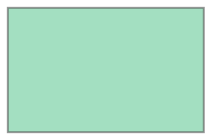

In [42]:
polygons_all[100][0].intersection( unary_union( polygons_all[100] ) )

In [57]:
current_dims

(1956, 8329)

In [58]:
current_filename

'/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/bracs_save_level4_npy/BRACS_1003667_level4.npy'

In [107]:
container_all = []
container_labels_all = []
for n in range( len(annotation_list) ):
    current_filename = get_slide_file_path( annotation_list[n].strip('.geojson') )
    current_img_np = np.load(current_filename)
    current_label = np.array(labels_all[n])
    current_annots = np.array(polygons_all[n])
    current_xdim = current_img_np.shape[1]
    current_ydim = current_img_np.shape[0]
    #print(current_dims, current_annots)

    # generate all patches based on slide level dimensions
    grid_cells_all = []
    grid_cells_all_np = []
    for x in range(0, current_xdim//224*224, 224):
        for y in range(0, current_ydim//224*224, 224):
            grid_cells_all.append(shapely.geometry.box(x, y, x+224, y+224))
            grid_cells_all_np.append(np.array([x, y]))
            
    grid_cells_all_np = np.array(grid_cells_all_np)
    
    # do this for all types of annotation present in the current slide
    current_uqs = np.unique(current_label)
    
    #container_all = []
    #container_labels_all = []
    for u in range( current_uqs.shape[0] ):
        # logical filter for current annotation
        filt_uq = current_label == current_uqs[u]
        #print(current_label, current_uqs[u], filt_uq.sum())
        
        _, intersections_list_area = intersect_annots_with_patches( grid_cells_all, current_annots[filt_uq] )
        
        topleft_read_from = grid_cells_all_np[np.nonzero(intersections_list_area)[0]]
        #topleft_read_from = grid_cells_all_np[ np.array(intersections_list_area) > 0 ] # at least 20% overlap (224/5)**2
        #if len(topleft_read_from) == 0:
        #print('numread:', topleft_read_from, filt_uq.sum())
        
        container = np.empty( (topleft_read_from.shape[0], 224, 224, 3), dtype=np.uint8 )
        container_labels = np.repeat(current_uqs[u], container.shape[0])
        #print(n ,'into:', current_uqs[u], container_labels, container.shape)
        for p in range(topleft_read_from.shape[0]):
            #print('ppp', p, topleft_read_from.shape[0])
            #print(topleft_read_from[p,0], topleft_read_from[p,0]+224, topleft_read_from[p,1], topleft_read_from[p,1]+224)
            container[p] = current_img_np[ topleft_read_from[p,1]:topleft_read_from[p,1]+224, 
                                           topleft_read_from[p,0]:topleft_read_from[p,0]+224, :]
        container_all.append(container)
        container_labels_all.append(container_labels)
        
        #print( current_uqs[u], grid_cells_all_np[np.nonzero(np.array(intersections_list_area))[0]] )

container_all = np.concatenate(container_all)
container_labels_all = np.concatenate(container_labels_all)

In [108]:
container_all.shape, container_labels_all.shape

((7763, 224, 224, 3), (7763,))

In [109]:
base_folder = '/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/'

In [110]:
%%time
np.save(base_folder+'bracs_level4_regions_224_data.npy', container_all)
np.save(base_folder+'bracs_level4_regions_224_label.npy', container_labels_all)

CPU times: user 2.32 ms, sys: 612 ms, total: 615 ms
Wall time: 612 ms


In [111]:
Counter( container_labels_all )

Counter({'PATHOLOGICAL-BENIGN': 1733,
         'UDH': 759,
         'INVASIVE-CARCINOMA': 1900,
         'NORMAL': 863,
         'ADH': 598,
         'FEA': 575,
         'DCIS': 1335})

(<matplotlib.image.AxesImage at 0x7fcf75e6dd30>, 'PATHOLOGICAL-BENIGN')

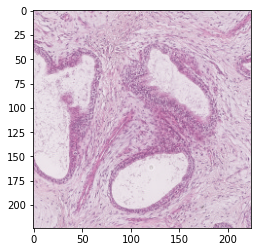

In [112]:
plt.imshow( container_all[10]), container_labels_all[10]

(<matplotlib.image.AxesImage at 0x7fcf7553ec40>, 'ADH')

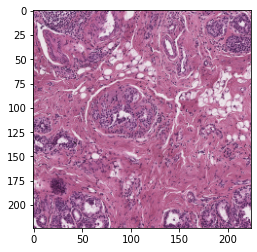

In [113]:
plt.imshow(container_all[1000]), container_labels_all[1000]

(<matplotlib.image.AxesImage at 0x7fcf754c6a60>, 'INVASIVE-CARCINOMA')

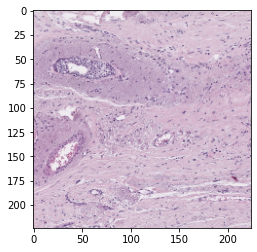

In [114]:
plt.imshow(container_all[2000]), container_labels_all[2000]